# PROJET - MT10 
Présenté par : LE MESTRE Cécile & RUDNICKI Benjamin

## Projet : réaliser un fond de cartes de l'Ile de France et y faire apparaître dans une couleur le trajet des avions qui atterrissent et dans une autre couleur le trajet des avions qui décollent.

Insertion des chemins d'accès aux fichiers:

In [1]:
import pandas as pd
filename1 = r"C:\Users\cecil\Benjamin_ADSB_EHS_RAW_20211007_dump1090.pkl"
filename2 = r"C:\Users\cecil\ADSB_EHS_RAW_20211007_dump1090.pkl"

Import, lecture et concaténation des fichiers de données personnelles :

In [70]:
df1 = pd.read_pickle(filename1)
df2 = pd.read_pickle(filename2)
df = pd.concat([df1, df2])
df = df.sort_values("timestamp").reset_index(drop=True)
df.columns # permet de connaître les informations présentes dans les fichiers de données

Index(['timestamp', 'icao24', 'squawk', 'latitude', 'longitude', 'altitude',
       'onground', 'groundspeed', 'roll', 'TAS', 'track', 'track_rate', 'IAS',
       'heading', 'Mach', 'vertical_rate_barometric', 'vertical_rate_inertial',
       'vertical_rate', 'geoaltitude', 'callsign', 'selected_fms',
       'selected_mcp', 'barometric_setting'],
      dtype='object')

Recherche du nombre d'avions détectés dans les données récupérées :

In [3]:
from bibliotheque.fonctions import iterate_icao24_callsign

sum(1 for _ in iterate_icao24_callsign(df))

391

Utilisation des classes FlightCollection et Collection afin de récupérer les données pour chaque avion : 

In [4]:
from bibliotheque.flightCollection import FlightCollection
from bibliotheque.flight import Flight

collection = FlightCollection(df)

Histogramme de la totalité des vitesses verticales récupérées dans le but de définir une vitesse verticale minimum pour ne pas prendre en compte les avions qui ne sont pas en train de décoller ou d'atterir.

<AxesSubplot:ylabel='Frequency'>

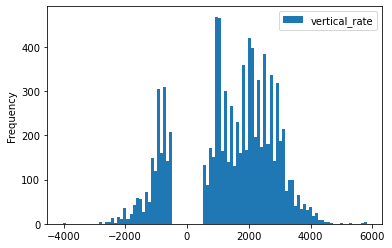

In [5]:
df[["vertical_rate"]].query("abs(vertical_rate) > 500").plot.hist(bins=100)

Tableau indiquant pour chaque vol l'altitude minimale et la date correspondante, l'altitude maximale et la date correspondante ainsi que la vitesse verticale moyenne.

In [6]:
import numpy as np
from bibliotheque.fonctions import iterate_all

# df.altitude.view(np.int64).plot.hist(bins=100)
pd.DataFrame.from_records(
    [
        {
            "icao24": chunk.icao24.min(),
            "callsign": chunk.callsign.min(),
            "altmin": chunk.altitude.min(),
            "time_alt_min": chunk.query("altitude == altitude.min()").timestamp.min(),
            "altmax": chunk.altitude.max(),
            "time_alt_max": chunk.query("altitude == altitude.max()").timestamp.max(),
            "vertical_rate": chunk.vertical_rate.mean(),
        }
        for chunk in iterate_all(df, 20000)
    ]
)

,icao24,callsign,altmin,time_alt_min,altmax,time_alt_max,vertical_rate
0,01013c,MSR985,32000.0,2021-10-07 12:14:16.701883+00:00,32000.0,2021-10-07 12:33:11.382843+00:00,0.000000
1,02010d,MAC112F,34650.0,2021-10-07 12:14:32.200657+00:00,39000.0,2021-10-07 12:35:06.898717+00:00,283.701493
2,02a195,TAR722,3925.0,2021-10-07 15:24:09.363712+00:00,5250.0,2021-10-07 15:20:51.100932+00:00,-731.428571
3,06a04a,QTR17W,33000.0,2021-10-07 13:23:59.339788+00:00,33000.0,2021-10-07 13:42:44.967784+00:00,0.000000
4,06a071,QTR7HK,34000.0,2021-10-07 12:11:21.816367+00:00,34000.0,2021-10-07 12:11:33.431173+00:00,0.000000
...,...,...,...,...,...,...,...
389,ab1d30,DAL85,10475.0,2021-10-07 14:50:58.091282+00:00,11450.0,2021-10-07 14:53:51.117254+00:00,1136.000000
390,ab4bf7,DAL39,32000.0,2021-10-07 12:36:59.775825+00:00,32000.0,2021-10-07 12:49:01.838791+00:00,0.000000
391,ab538b,DAL149,34000.0,2021-10-07 12:16:40.023485+00:00,34000.0,2021-10-07 12:29:56.044427+00:00,0.000000
392,adc5cd,N987GT,1100.0,2021-10-07 13:55:38.934249+00:00,1100.0,2021-10-07 13:55:38.934249+00:00,NaN


On remarque que les avions volant à une altitude d'environ 30 000 mètres ont une vitesse verticale nulle, ils ne sont ni en train de décoller ni d'atterrir.


Courbe de l'altitude d'un avion en fonction du temps:

<AxesSubplot:xlabel='timestamp'>

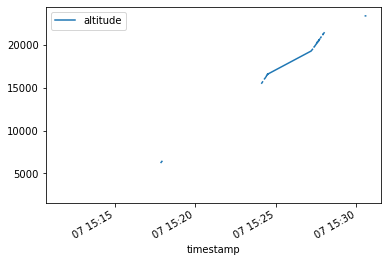

In [7]:
bigger_chunk = df.query('icao24 == "06a133"')
bigger_chunk.agg(dict(altitude=["min", "max"]))

bigger_chunk.plot(x="timestamp", y="altitude")

## Création du fond de carte de l'île de France

Import des bibliothèques nécessaires :

In [8]:
import geopandas as gpd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, shape
from descartes import PolygonPatch

Import des autoroutes :

In [9]:
# Importer le bon chemin d'accès au fichier TRONCON_ROUTE.shp ci-dessous
fichier_routes = r"C:\Users\cecil\pyweek\projet\ROUTE500_3-0__SHP_LAMB93_FXX_2021-05-21\ROUTE500\1_DONNEES_LIVRAISON_2021-05-00142\R500_3-0_SHP_LAMB93_FXX-ED211\RESEAU_ROUTIER\TRONCON_ROUTE.shp"
routes = gpd.read_file(fichier_routes)
    
from bibliotheque.fonctions import autoroute_geom

# Récupération de la géométrie des autoroutes
autoroutegeometry = autoroute_geom(routes)

Import des communes :

In [10]:
# Importer le bon chemin d'accès au fichier COMMUNES.shp ci-dessous
fichier_communes = r"C:\Users\cecil\pyweek\projet\ROUTE500_3-0__SHP_LAMB93_FXX_2021-05-21\ROUTE500\1_DONNEES_LIVRAISON_2021-05-00142\R500_3-0_SHP_LAMB93_FXX-ED211\ADMINISTRATIF\COMMUNE.shp"
filin = gpd.read_file(fichier_communes)
    
# Récupération de la géométrie des communes
nom_commune = [p for p in filin["ID_RTE500"]]
communesgeometry = [p for p in filin["geometry"]]

Import des fleuves :

In [11]:
# Importer le bon chemin d'accès au fichier COMMUNES.shp ci-dessous
fichier_fleuve = r"C:\Users\cecil\pyweek\projet\ROUTE500_3-0__SHP_LAMB93_FXX_2021-05-21\ROUTE500\1_DONNEES_LIVRAISON_2021-05-00142\R500_3-0_SHP_LAMB93_FXX-ED211\HABILLAGE\TRONCON_HYDROGRAPHIQUE.shp"
fleuve = gpd.read_file(fichier_fleuve)

# Récupération de la géométrie des fleuves
nom_fleuve = [p for p in fleuve["TOPONYME"]]
fleuvegeometry = [p for p in fleuve["geometry"]]

Traçage du parcours des avions qui décolent et atterrissent en île-de-france.

[]

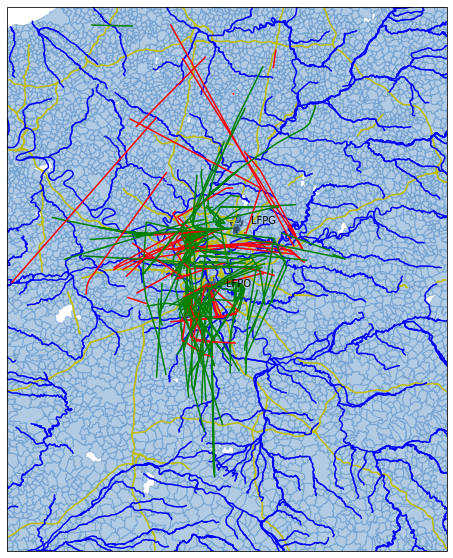

In [15]:
import matplotlib.pyplot as plt
from cartopy.crs import EuroPP, PlateCarree
from traffic.data import airports
from cartes.crs import Lambert93

# Détermination de l'axe ax de la figure en Lambert93
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=Lambert93()))

# Position des aéroports Orly et Charles de Gaulle sur le fond de carte
airports["CDG"].point.plot(ax)
airports["ORY"].point.plot(ax)

from bibliotheque.fonctions import carte_route
from bibliotheque.fonctions import carte_fleuve
from bibliotheque.fonctions import carte_commune

# Ecriture du fond de carte
carte_route(autoroutegeometry,ax)
carte_fleuve(fleuvegeometry,ax)
carte_commune(communesgeometry,ax)

# Ajout des avions qui décollent en vert et des avions qui atterrissent en rouge sur le fond de carte
for flight in collection:
    if flight.decol_atter() == "décollage":
        flight.plotr(ax, color="green")
    elif flight.decol_atter() == "atterissage":
        flight.plotr(ax, color="red")
        
ax.set_extent((1, 4, 47.5, 50))
ax.set_yticks([])

In [ ]:
%load_ext lab_black

# Bonus : 
## Récupération des informations sur le vent

In [21]:
pd.DataFrame.from_records(
    [
        {
            "icao24": chunk.icao24.min(),
            "callsign": chunk.callsign.min(),
            "TAS": chunk.TAS,
            "groundspeed": chunk.groundspeed,
            "heading": chunk.heading,
            "track": chunk.track
        }
        for chunk in iterate_all(df, 20000)
    ]
)

,icao24,callsign,TAS,groundspeed,heading,track
0,01013c,MSR985,1733 490.0 1903 NaN 1905 NaN 1...,1733 462.0 1903 NaN 1905 NaN 1...,1733 NaN 1903 326.074 1905 ...,1733 321.680 1903 NaN 1905 ...
1,02010d,MAC112F,2806 NaN 2863 NaN 2870 NaN 2875 Na...,2806 NaN 2863 NaN 2870 NaN 2...,2806 NaN 2863 NaN 2870 202...,2806 NaN 2863 NaN 2870 Na...
2,02a195,TAR722,143209 NaN 143387 NaN 144337 Na...,143209 287.0 143387 288.0 144337 Na...,143209 NaN 143387 NaN 144337 ...,143209 272.790 143387 272.780 144337 ...
3,06a04a,QTR17W,74537 NaN 74686 NaN 74945 NaN 74949 Na...,74537 447.0 74686 NaN 74945 NaN 7...,74537 NaN 74686 141.504 74945 ...,74537 140.62 74686 NaN 74945 Na...
4,06a071,QTR7HK,468 NaN 482 NaN 693 NaN 772 NaN 10...,468 NaN 482 NaN 693 NaN 772 ...,468 322.559 482 322.559 693 322.55...,468 NaN 482 NaN 693 NaN 772 ...
...,...,...,...,...,...,...
389,ab1d30,DAL85,126764 NaN 127417 NaN 129197 Na...,126764 274.0 127417 282.0 129197 Na...,126764 NaN 127417 NaN 129197 ...,126764 302.940 127417 279.360 129197 ...
390,ab4bf7,DAL39,38985 NaN 39302 NaN 42026 472.0 4...,38985 NaN 39302 442.0 42026 444.0 4...,38985 324.141 39302 NaN 42026 ...,38985 NaN 39302 323.36 42026 322.9...
391,ab538b,DAL149,12259 NaN 12582 NaN 12583 NaN 1...,12259 436.0 12582 NaN 12583 NaN 1...,12259 NaN 12582 325.371 12583 ...,12259 326.020 12582 NaN 12583 ...
392,adc5cd,N987GT,"98900 NaN Name: TAS, dtype: float64","98900 NaN Name: groundspeed, dtype: float64","98900 NaN Name: heading, dtype: float64","98900 NaN Name: track, dtype: float64"


Calcul des coordonnée du vent.

In [75]:
import math

WS = []
WDIR = []

#df = df.query("TAS != NaN")

for i in range (0,len(df)) : 
    al = df['heading'][i] - df['track'][i]
    WS_i = math.sqrt(df['TAS'][i]**2 + df['groundspeed'][i]**2 - 2*df['TAS'][i]*df['groundspeed'][i]*math.cos(al))
    WDIR_i = math.acos((df['TAS'][i]**2-df['groundspeed'][i]**2-WS_i**2)/(2*WS_i*df['groundspeed'][i]))
    WS.append(WS_i)
    WDIR.append(WDIR_i)
    
# manque de quantité d'informations valides pour obtenir un résultat 


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
152069    404.0
152070      NaN
152071      NaN
152072      NaN
152073      NaN
Name: TAS, Length: 152074, dtype: float64